<a href="https://colab.research.google.com/github/Shirley-Dongxx/APS360_project/blob/main/APS360_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360 Project: Facial Age Progression and Regression


---
Contents to be added:


*   Image Preprocessing
*   CAAE Architecture
*   GAN Architecture
*   Baseline (optional)




## Data Preprocessing



*   Dataset used: The IMDB-WIKI dataset (only the WIKI set will be used)
*   Download the WIKI face only dataset at: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/


**What you need to do before running the code**

1.   Create a new folder called APS360_project directly under your MyDrive folder (in case you don't want to change any of the file paths in the code)
2.   Upload the wiki_crop dataset to your APS360_project folder (At present I am only testing on the folder 0-9)
3.   Upload the wiki.mat file to the APS360_project folder (which should have been included in your unzipped wiki_crop folder)
4.   Create a new folder called wiki_processed directly under APS360_project
5.   Within the wiki_processed folder, create 3 folders named "train", "validation" and "test"
6.   Within the above 3 folders, create 2 folders named "female" and "male" (since we want to train the two genders separately)
7.   Within the gender folders, create 10 folders with folder name from 0-9

*(will try to write a function to generate the folders automatically)*


### Import data from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load the mat file of the Wiki dataset


**Reference**

@article\
{Rothe-IJCV-2018,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},\
  title = {Deep expectation of real and apparent age from a single 
  image without facial landmarks},\
  journal = {International Journal of Computer Vision},\
  volume={126},\
  number={2-4},\
  pages={144--157},\
  year={2018},\
  publisher={Springer}
}

@InProceedings\
{Rothe-ICCVW-2015,\
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},\
  title = {DEX: Deep EXpectation of apparent age from a single image},\
  booktitle = {IEEE International Conference on Computer Vision Workshops (ICCVW)},\
  year = {2015}, \
  month = {December},\
}



In [2]:
from datetime import datetime, timedelta
from scipy.io import loadmat
import numpy as np
import pandas as pd
import scipy
import os
import imghdr
import matplotlib.pyplot as plt

from collections import defaultdict
from pprint import pprint
from shutil import copy2

import cv2
import sys
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

In [3]:
# convert the matlab styled date to number
def matlab_datenum_to_dt(matlab_datenum):
    return datetime.fromordinal(int(matlab_datenum) - 366) + timedelta(days=int(matlab_datenum % 1))

In [4]:
# load wiki metadata
# Modified from https://gist.github.com/messefor/e2ee5fe1c18a040c90bbf91f2ee279e3

def load_wiki_meta():

    # Please change to your own path when testing!
    file_path = "/content/gdrive/MyDrive/APS360_project/wiki.mat"
    save_path = "/content/gdrive/MyDrive/APS360_project/wiki.pkl"

    mat = loadmat(file_path)

    print("Data header:",mat['__header__'])
    print("Data Version:",mat['__version__'])

    # Extract values
    data = mat['wiki'][0, 0]
    print("Column names are: ", data.dtype.names)

    # Data loaded in simple form
    col_keys = ('dob', 'photo_taken', 'gender', 'face_location', 'face_score', 'second_face_score')
    col_values = {k: data[k].squeeze() for k in col_keys}

    # Data loaded into numpy arrays
    col_keys_nested = ('full_path', 'name')
    for key in col_keys_nested:
        col_values[key] = np.array([x if not x else x[0] for x in data[key][0]])
    #print(col_values['name'][5])

    # Convert face location to DataFrame
    # Inputs:
    #    img - image (i.e. load with imread)
    #    box - location of face (i.e. img(box(2):box(4),box(1):box(3),:))
    #    crop_margin - margin around face as a fraction of the width, height
    #    [left above right below], default is [0.4 0.4 0.4 0.4]
    col_values['face_location'] =[tuple(x[0].tolist()) for x in data['face_location'].squeeze()]

    # Check all values extracted have same length
    set_nrows = {len(v) for _, v in col_values.items()}
    assert len(set_nrows) == 1

    # convert to panda data frame
    df_values = pd.DataFrame(col_values)

    # Convert matlab datenum to datetime
    df_values['dob'] = df_values['dob'].apply(matlab_datenum_to_dt)

    # Calculate ages when photo was taken
    df_values['photo_taken_age'] = df_values.apply(lambda x: x['photo_taken'] - x['dob'].year, axis=1)

    # Concat all together and save
    # Do not use csv format to work around tuple to be string
    df_values.to_pickle(save_path)

load_wiki_meta()

Data header: b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016'
Data Version: 1.0
Column names are:  ('dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [5]:
# check if the image is in the correct format
DATA_PATH_FILTERED = "/content/gdrive/MyDrive/APS360_project/00"
def check_path():
  count = 0
  for root, dirs, files in os.walk(DATA_PATH_FILTERED, topdown = False):
    for name in files:
      print("loading...")
      filepath = os.path.join(root, name)
      count += 1
      if imghdr.what(filepath) is not 'jpeg':
        print(filepath)
  print(count)

### Load the image into different datasets with labels

**The separation of image labels**

The image labels are separated based on the age of the person when the photo was taken.

Label  | Age Range (Inclusive)
-------------------|------------------
0      | 0-5
1     | 6-10
2      | 11-15
3    | 16-20 
4      | 21-30
5     | 31-40 
6      | 41-50
7     | 51-60
8      | 61-70
9     | 71+ 



In [21]:
# record the paths of data and metadata
# please change to your own path when running
META_PATH = "/content/gdrive/MyDrive/APS360_project/wiki.pkl"


IMG_SIZE = 2048

# count the number of faces in the image
def count_face(imagePath):

  image = cv2.imread(imagePath)
  #cv2_imshow(image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  faces = faceCascade.detectMultiScale(
      gray,
      scaleFactor=1.3,
      minNeighbors=3,
      minSize=(30, 30)
  )

  print("[INFO] Found {0} Faces.".format(len(faces)))
  return len(faces)

# get the gender of the image
def get_gender(gender):
    if(gender == 1.0):
      return "male"
    else:
      return "female"

# check if the image is valid
def check_valid_image(path):
    # if no image can be retrieved from the path
    if not (os.path.isfile(path)):
      print("Invalid Path!")
      return False

    # if the size of the image is too large
    if not (os.path.getsize(path) > IMG_SIZE):
      print("Invalid Size!")
      return False
    
    # if there are no faces or too many faces
    if (count_face(path)!=1):
      print("No face discovered!")
      return False

    return True

# check if the age of the person is in our range
def check_valid_age(age):
    if (age < 0 or age > 100):
      return False
    return True

In [8]:
#if(check_valid_image("/content/gdrive/MyDrive/APS360_project/wiki_crop/00/10126400_1964-07-07_2010.jpg")==True):
  #print("Valid Image")
#else:
  #print("Invalid Image")

In [7]:
def get_age_label(age):
    if 0 <= age <= 5:
        label = 0
    elif 6 <= age <= 10:
        label = 1
    elif 11 <= age <= 15:
        label = 2
    elif 16 <= age <= 20:
        label = 3
    elif 21 <= age <= 30:
        label = 4
    elif 31 <= age <= 40:
        label = 5
    elif 41 <= age <= 50:
        label = 6
    elif 51 <= age <= 60:
        label = 7
    elif 61 <= age <= 70:
        label = 8
    else:
        label = 9

    return label

In [8]:
def getBaseFilename(filename):
    return filename.split('/')[-1]

In [9]:
def get_folder(filename):
    return int(filename.split('/')[0])

In [22]:
def print_age_distribution(age_count):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  age_label = [0,1,2,3,4,5,6,7,8,9]
  count_label = age_count
  ax.bar(age_label,count_label)
  plt.show()

In [19]:
DATA_PATH = "/content/gdrive/MyDrive/APS360_project/wiki_crop"
DATA_SAVE_PATH = "/content/gdrive/MyDrive/APS360_project/wiki_processed"

def process_wiki_image(file_test = False):
    age_count = [0,0,0,0,0,0,0,0,0,0]
    meta = pd.read_pickle(META_PATH)

    # Limit the age of the dataset set
    meta = meta[meta['photo_taken_age'] >= 0]
    meta = meta[meta['photo_taken_age'] <= 101]

    # Converting into numpy array
    meta = meta.values
    print(meta[0])

    # Split dataset into training validation and testing set
    D_train, D_test = train_test_split(meta, test_size=0.15, random_state=42)
    D_train, D_val = train_test_split(D_train, test_size=0.15, random_state=55)

    # Load the training set
    # test a few images at first
    n = 0
    for i in range(len(D_train)):
      # [datetime.datetime(1989, 10, 12, 0, 0) 2013 1.0
      #(138.69, 61.41, 187.68, 110.4) 1.6635990063177242 nan
      #'52/37792752_1989-10-12_2013.jpg' 'Dee Bost' 24]
      #print("Info: ", D_train[i])
      age = D_train[i][-1]
      #print("Age is", age)

      full_path = os.path.join(DATA_PATH, D_train[i][6])
      print("The path is:", full_path)

      # currently only testing on folder 0-9
      print("folder is: ",get_folder(D_train[i][6]))

      n += 1
      print("n=",n)

      if file_test and n>9:
        print("Testing end...")
        print_age_distribution(age_count)
        return

      if get_folder(D_train[i][6])>9:
        print("out")
        new_age = None
        continue

      #if not os.path.isdir(full_path):
       # print("wrong path")
       # continue

      if not check_valid_image(full_path):
        print("awwwww")
        continue

      gender = get_gender(D_train[i][2])
      age_label = get_age_label(age)
      age_count[age_label] += 1
      age_label = str(age_label)

      new_file_path = DATA_SAVE_PATH + "/train/"+ gender + "/" + age_label +"/"
      print("The new file path is:", new_file_path)

      # check if the folder exists
      if not os.path.isdir(new_file_path):
        print("Folder not found!")

      new_file_path = os.path.join(new_file_path, getBaseFilename(D_train[i][6]))
      if(file_test): 
        print("Now, the new file path is:", new_file_path)

      copy2(full_path, new_file_path)
      if(file_test):
        print("copy finished")

[datetime.datetime(1981, 5, 5, 0, 0) 2009 1.0
 (111.29109473290997, 111.29109473290997, 252.66993081807996, 252.66993081807996)
 4.3009623883308095 nan '17/10000217_1981-05-05_2009.jpg'
 'Sami Jauhojärvi' 28]
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/11/44164711_1985-03-27_2014.jpg
folder is:  11
n= 1
out
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/13/1883213_1962-01-12_2007.jpg
folder is:  13
n= 2
out
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/40/38833240_1929-06-10_1975.jpg
folder is:  40
n= 3
out
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/22/4353022_1970-06-07_2011.jpg
folder is:  22
n= 4
out
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/92/14541592_1925-03-02_1976.jpg
folder is:  92
n= 5
out
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/26/421426_1916-10-10_1958.jpg
folder is:  26
n= 6
out
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/01/27347801_1904-04-22_19

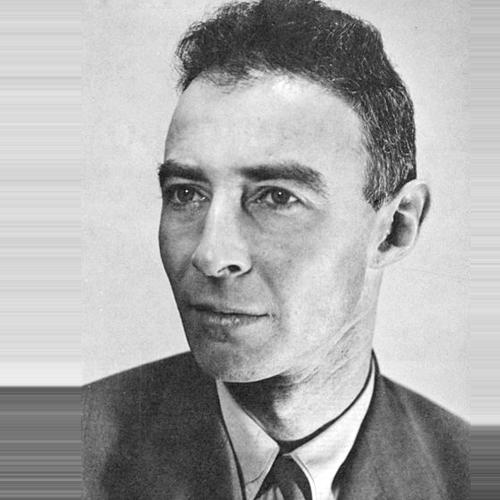

[INFO] Found 1 Faces.
The new file path is: /content/gdrive/MyDrive/APS360_project/wiki_processed/train/male/5/
Now, the new file path is: /content/gdrive/MyDrive/APS360_project/wiki_processed/train/male/5/27347801_1904-04-22_1944.jpg
copy finished
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/56/40953956_1928-03-11_2013.jpg
folder is:  56
n= 8
out
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/51/2597051_1980-11-22_2010.jpg
folder is:  51
n= 9
out
The path is: /content/gdrive/MyDrive/APS360_project/wiki_crop/59/7283759_1976-09-24_2005.jpg
folder is:  59
n= 10
Testing end...


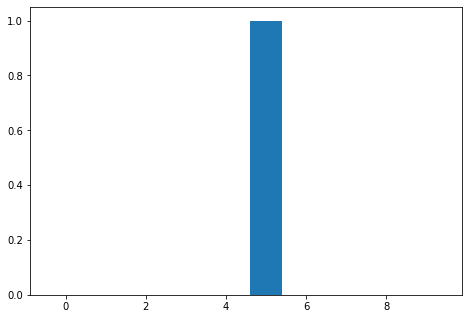

In [20]:
# for testing purpose only
process_wiki_image(file_test = True)

In [14]:
# for testing use only
DATA_PATH = "/content/gdrive/MyDrive/APS360_project/wiki_crop"
DATA_SAVE_PATH = "/content/gdrive/MyDrive/APS360_project/wiki_processed"

meta = pd.read_pickle(META_PATH)
full_path = os.path.join(DATA_PATH, meta['full_path'][10])
print("The path is: ", full_path)

gender = get_gender(meta['gender'][10])
age_label = get_age_label(meta['photo_taken_age'][10])

new_file_path = DATA_SAVE_PATH + "/train/"+ (gender) + "/" + str(age_label) +"/"
print("The new file path is:", new_file_path)
new_file_path = os.path.join(new_file_path, getBaseFilename(meta['full_path'][10]))
print("Now, the new file path is:", new_file_path)

The path is:  /content/gdrive/MyDrive/APS360_project/wiki_crop/99/10004299_1908-08-19_1950.jpg
The new file path is: /content/gdrive/MyDrive/APS360_project/wiki_processed/train/male/6/
Now, the new file path is: /content/gdrive/MyDrive/APS360_project/wiki_processed/train/male/6/10004299_1908-08-19_1950.jpg
